### Cryptocurrency price prediction

Writer: Ha-young Park, mintyoung@gm.gist.ac.kr  
PI: Heung-no Lee, heungno@gist.ac.kr

Load libraries

In [409]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Activation
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
import math

Load dataset

In [452]:
data = pd.read_csv('.\dataset\historical-price-data.csv')

In [453]:
# Remove some columns
data = data.drop(columns = ['Open', 'High', 'Low', 'Adj Close', 'Volume'])

In [454]:
# Set 'Date' as index
data.set_index('Date')

,Close
Date,
2020.01.01,55.046360
2020.01.02,54.826622
2020.01.03,54.742420
2020.01.04,54.865559
2020.01.05,54.384300
...,...
2021.12.27,12.542370
2021.12.28,12.520440
2021.12.29,12.799864


In [455]:
data.isnull().sum()

Date     0
Close    1
dtype: int64

In [456]:
# Remove missing value
data = data.dropna()
data.isnull().sum()

Date     0
Close    0
dtype: int64

In [457]:
dataset = data.values

train_data_len = math.ceil(len(dataset) * .7)

train_data_len

511

Data normalization

In [458]:
scaler = MinMaxScaler(feature_range=(0,1))
scale_cols = ['Close']
scaled_close_data = scaler.fit_transform(data[scale_cols])
scaled_df = pd.DataFrame(scaled_close_data, columns= scale_cols)

In [459]:
scaled_df

,Close
0,0.953016
1,0.948221
2,0.946383
3,0.949071
4,0.938568
...,...
725,0.025441
726,0.024962
727,0.031060
728,0.028953


In [460]:
scaled_df = scaled_df.join(data['Date'])

In [461]:
# Set 'Date' as index
scaled_df.columns
scaled_df.set_index('Date')

,Close
Date,
2020.01.01,0.953016
2020.01.02,0.948221
2020.01.03,0.946383
2020.01.04,0.949071
2020.01.05,0.938568
...,...
2021.12.26,0.025441
2021.12.27,0.024962
2021.12.28,0.031060


Make window & Split training and testing data.

In [462]:
feature_cols = ['Close','Date']
label_cols = ['Close', 'Date']
label_df = pd.DataFrame(scaled_df, columns=label_cols)
feature_df = pd.DataFrame(scaled_df, columns=feature_cols)

label_df = label_df.set_index(keys='Date')
feature_df = feature_df.set_index(keys='Date')

print(feature_df)
print(label_df)

               Close
Date                
2020.01.01  0.953016
2020.01.02  0.948221
2020.01.03  0.946383
2020.01.04  0.949071
2020.01.05  0.938568
...              ...
2021.12.26  0.025441
2021.12.27  0.024962
2021.12.28  0.031060
2021.12.29  0.028953
2021.12.30  0.026137

[730 rows x 1 columns]
               Close
Date                
2020.01.01  0.953016
2020.01.02  0.948221
2020.01.03  0.946383
2020.01.04  0.949071
2020.01.05  0.938568
...              ...
2021.12.26  0.025441
2021.12.27  0.024962
2021.12.28  0.031060
2021.12.29  0.028953
2021.12.30  0.026137

[730 rows x 1 columns]


In [463]:
label_np = label_df.to_numpy()
feature_np = feature_df.to_numpy()

In [464]:
def make_sequence_dataset(feature, label, window_size):
    feature_list = []
    label_list = []

    for i in range(len(feature) - window_size):
        feature_list.append(feature[i:i+window_size])
        label_list.append(label[i+window_size])
    
    return np.array(feature_list), np.array(label_list)

In [465]:
window_size = 40

X, Y = make_sequence_dataset(feature_np, label_np, window_size)

print(X.shape, Y.shape)

(690, 40, 1) (690, 1)


In [466]:
split = -200
x_train = X[0:split]
y_train = Y[0:split]

x_test = X[split:]
y_test = Y[split:]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(490, 40, 1) (490, 1)
(200, 40, 1) (200, 1)


Build a LSTM Model     

In [467]:
model = Sequential()
model.add(LSTM(40, return_sequences = True, input_shape = (40,1)))
model.add(LSTM(64, return_sequences = False))
model.add(Dense(1, activation='linear'))

In [468]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics = ['mae'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 40, 40)            6720      
                                                                 
 lstm_23 (LSTM)              (None, 64)                26880     
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 33,665
Trainable params: 33,665
Non-trainable params: 0
_________________________________________________________________


In [469]:
# Train the model
model.fit(x_train, y_train,
    validation_data = (x_test, y_test),
    batch_size = 10,
    epochs = 20)

Epoch 1/20
49/49 [==============================] - 7s 66ms/step - loss: 0.0261 - mae: 0.1080 - val_loss: 0.0059 - val_mae: 0.0746
Epoch 2/20
49/49 [==============================] - 1s 29ms/step - loss: 0.0036 - mae: 0.0471 - val_loss: 7.9000e-04 - val_mae: 0.0238
Epoch 3/20
49/49 [==============================] - 2s 32ms/step - loss: 0.0027 - mae: 0.0399 - val_loss: 4.0990e-04 - val_mae: 0.0162
Epoch 4/20
49/49 [==============================] - 2s 48ms/step - loss: 0.0024 - mae: 0.0382 - val_loss: 3.9142e-04 - val_mae: 0.0154
Epoch 5/20
49/49 [==============================] - 1s 29ms/step - loss: 0.0019 - mae: 0.0343 - val_loss: 3.8983e-04 - val_mae: 0.0150
Epoch 6/20
49/49 [==============================] - 2s 38ms/step - loss: 0.0018 - mae: 0.0322 - val_loss: 3.2049e-04 - val_mae: 0.0134
Epoch 7/20
49/49 [==============================] - 1s 27ms/step - loss: 0.0017 - mae: 0.0320 - val_loss: 3.0274e-04 - val_mae: 0.0147
Epoch 8/20
49/49 [==============================] - 1s 28ms

In [470]:
model.evaluate(x_test,y_test)

7/7 [==============================] - 1s 16ms/step - loss: 2.3736e-04 - mae: 0.0117


[0.00023735994182061404, 0.011729743331670761]

Test

7/7 [==============================] - 1s 18ms/step


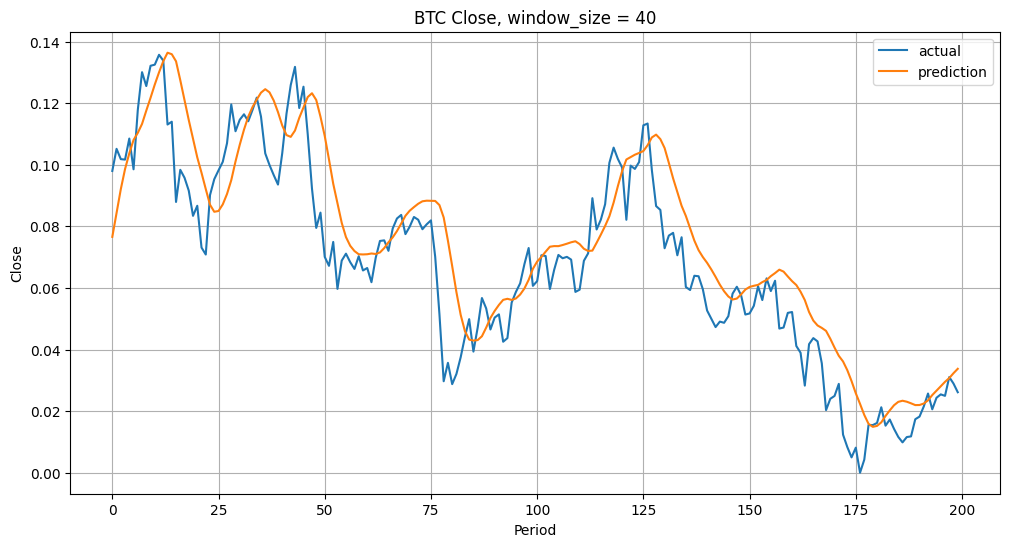

In [471]:
test_pred = model.predict(x_test)

plt.figure(figsize=(12,6))
plt.title('BTC Close, window_size = 40')
plt.ylabel('Close')
plt.xlabel('Period')
plt.plot(y_test, label = 'actual')
plt.plot(test_pred, label = 'prediction')
plt.grid()
plt.legend(loc = 'best')

plt.show()

In [472]:
test_pred

array([[0.07658523],
       [0.08430611],
       [0.09205844],
       [0.09861313],
       [0.10369636],
       [0.10805687],
       [0.11035167],
       [0.11326936],
       [0.11758442],
       [0.12173447],
       [0.12606078],
       [0.13000958],
       [0.13362682],
       [0.136386  ],
       [0.1359046 ],
       [0.13360499],
       [0.12747155],
       [0.12091181],
       [0.11450426],
       [0.10844907],
       [0.10239603],
       [0.09739795],
       [0.09211108],
       [0.08702047],
       [0.08473679],
       [0.08499196],
       [0.08712442],
       [0.09051311],
       [0.09499119],
       [0.1010693 ],
       [0.10651292],
       [0.11141182],
       [0.11563629],
       [0.11872451],
       [0.12118399],
       [0.12341991],
       [0.12454937],
       [0.12351748],
       [0.1208491 ],
       [0.11709854],
       [0.11274667],
       [0.10964501],
       [0.10905944],
       [0.11111248],
       [0.11521502],
       [0.11860774],
       [0.12199466],
       [0.123

In [473]:
y_test

array([[0.09799136],
       [0.10517857],
       [0.10183125],
       [0.10167519],
       [0.10850982],
       [0.09853173],
       [0.11778739],
       [0.13007131],
       [0.12555955],
       [0.13214487],
       [0.13250692],
       [0.13571548],
       [0.13384195],
       [0.11306837],
       [0.11398174],
       [0.08792654],
       [0.09836209],
       [0.09578606],
       [0.09159158],
       [0.08341624],
       [0.08669032],
       [0.07311326],
       [0.07085375],
       [0.09016065],
       [0.09531585],
       [0.09819032],
       [0.10095426],
       [0.10698708],
       [0.11957806],
       [0.1108888 ],
       [0.1146221 ],
       [0.11639609],
       [0.11413605],
       [0.11779826],
       [0.12180571],
       [0.11563575],
       [0.1036945 ],
       [0.09992634],
       [0.09663653],
       [0.09357025],
       [0.10376782],
       [0.1165678 ],
       [0.1259044 ],
       [0.13179245],
       [0.11843279],
       [0.12535005],
       [0.10990533],
       [0.092

In [474]:
# Inverse
scaler.inverse_transform(y_test)

array([[15.866826],
       [16.196163],
       [16.04278 ],
       [16.035629],
       [16.34881 ],
       [15.891587],
       [16.773933],
       [17.336815],
       [17.130074],
       [17.431831],
       [17.448421],
       [17.595446],
       [17.509596],
       [16.557695],
       [16.599548],
       [15.405629],
       [15.883814],
       [15.765773],
       [15.573571],
       [15.198955],
       [15.348982],
       [14.726845],
       [14.623308],
       [15.508002],
       [15.744227],
       [15.875943],
       [16.002594],
       [16.279034],
       [16.855986],
       [16.457821],
       [16.628891],
       [16.71018 ],
       [16.606619],
       [16.774431],
       [16.958063],
       [16.675339],
       [16.128159],
       [15.955492],
       [15.804744],
       [15.664239],
       [16.131519],
       [16.718048],
       [17.145876],
       [17.415682],
       [16.803507],
       [17.120474],
       [16.412756],
       [15.603904],
       [15.01902 ],
       [15.246863],


In [475]:
pred_inverse = scaler.inverse_transform(test_pred)
pred_inverse

array([[14.88594  ],
       [15.239732 ],
       [15.594964 ],
       [15.895317 ],
       [16.128244 ],
       [16.328054 ],
       [16.433208 ],
       [16.566904 ],
       [16.764633 ],
       [16.954798 ],
       [17.153042 ],
       [17.333986 ],
       [17.499737 ],
       [17.626171 ],
       [17.604113 ],
       [17.498737 ],
       [17.217688 ],
       [16.917103 ],
       [16.623491 ],
       [16.346025 ],
       [16.06866  ],
       [15.839634 ],
       [15.597376 ],
       [15.364111 ],
       [15.259466 ],
       [15.271158 ],
       [15.368875 ],
       [15.524153 ],
       [15.729351 ],
       [16.007866 ],
       [16.257307 ],
       [16.481789 ],
       [16.675364 ],
       [16.816875 ],
       [16.929575 ],
       [17.03203  ],
       [17.083786 ],
       [17.0365   ],
       [16.914228 ],
       [16.742369 ],
       [16.542953 ],
       [16.400827 ],
       [16.373995 ],
       [16.468071 ],
       [16.656061 ],
       [16.811523 ],
       [16.966722 ],
       [17.02

Export

In [476]:
# Make 'pred' into data frame
pred_df = pd.DataFrame(pred_inverse ,columns = ['Close'])

In [477]:
pred_df

,Close
0,14.885940
1,15.239732
2,15.594964
3,15.895317
4,16.128244
...,...
195,12.663233
196,12.729054
197,12.784968
198,12.857700


In [478]:
# Export as csv
pred_df.to_csv('./predicted-price.csv')